Import the necessary libraries, nothing special here except for the [lmfit](https://lmfit.github.io/lmfit-py/index.html) library which is crucial to the fitting of the distribution to the data 

In [2]:
from lmfit import minimize, Parameters
from numpy import exp

import numpy as np
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

Source data is basically the goals scored by Stoke City FC in the 2012-2013 season after 23 matches
this is the sequence of the goals

[1,2,1,3,3,0,0,1,2,0,1,1,1,1,0,0,0,1,2,0,0,2,0]

organise the above data into 0,1,2,3,4,5 goals bins as that is easier to process for my purpose, 
if there's a match where Stoke scored more than 5 goals that would be put in the 5 goals bin

In [ ]:
teamname = 'Stoke FC'

team_goals_bins = [[0,9,teamname],[1,8,teamname],[2,4,teamname],[3,2,teamname],[4,0,teamname],[5,0,teamname]]

team_dataframe_goal_frequency = pd.DataFrame(team_goals_bins,columns=['goals','frequency','team'])

define 2 functions 

- **team_goals_pooled_bins(goals_scored)** returns the percentage of goals scored by goal bin essentially what can be called actual data
   - parameter1 -> **goals scored** list of goals scored by Stoke for each bin
   

- **zip_pmf(goals_bin, zero_adjustment, poisson_distribution_mean)** returns percentage of goals scored by goals bin as predicted by the distribution, 
   - parameter1 -> **goals_bin**, this is a list of 0 to 5 essentially since the distribution has to assign a percentage to each      goals bin

   - parameter2 -> **zero_adjustment**, this the parameter used to account for the excess number of zeros in the poisson              distribution

   - parameter3 -> **poisson_distribution_mean**, parameter used by poisson distribution which is generaly the weighted average      of whatever count data it's using,

for a normal poisson this will be  the sum of the goals scored multiplied by goal bin divided by sum of goals scored but of course it will be likely be different from poisson in this zero inflated case


In [9]:
def team_goals_pooled_bins(goals_scored):
    return goals_scored/np.sum(goals_scored)

def zip_pmf(goals_bin, zero_adjustment, poisson_distribution_mean):
    if zero_adjustment < 0 or zero_adjustment > 1 or poisson_distribution_mean <= 0:
        return np.zeros_like(goals_bin)
    else:
        return (goals_bin == 0) * (1 - zero_adjustment) + (zero_adjustment  * stats.poisson.pmf(goals_bin, poisson_distribution_mean))

list to store percentage of goals scored by bin, this is part of what will be used in calculating least squares

In [12]:
relative_frequency = team_goals_pooled_bins(team_dataframe_goal_frequency['frequency'])

these frequency weights were used by the author in the excel example but it seems as if the fit function of lmfit doesn't need 
them for parameter estimation, kept this code for reference purposes 

In [10]:

frequency_weight = (relative_frequency == 0) + 0 + (1/(relative_frequency*(1-relative_frequency)))
frequency_weight = np.where(frequency_weight == np.inf,0,frequency_weight)

adding initial parameters since in order for an optimization function to estimate paramaters it needs a starting point

In [11]:
params = Parameters()
params.add('zip_phi_param', value=0.5, min=0.0,max=1.0)
params.add('poisson_distribution_mean', value=2.0, min=1)

function to calculate the sum of squares residuals between the actual goals bin percentages  and zero inflated poisson probability distribution estimated percentages  


- **residual(params, zero_adjustment, poisson_distribution_mean)** returns percentage of goals scored by goals bin as predicted by the distribution, 
   - parameter1 -> **params**, initial parameters for the zero inflated poisson to be used in initial estimation

   - parameter2 -> **goals_bin**, this is a list of 0 to 5 essentially since the distribution has to assign a percentage to each      goals bin

   - parameter3 -> **actual_bin_percentage_data**, data to be passed by relative frequency list

In [13]:
def residual(params, goals_bin, actual_bin_percentage_data):
    zip_phi_param = params['zip_phi_param'].value
    poisson_distribution_mean = params['poisson_distribution_mean'].value
    zip_fitted_data = zip_pmf(goals_bin, zip_phi_param, poisson_distribution_mean)
    return (actual_bin_percentage_data-zip_fitted_data)

this is where the magic happens from a mathematical optimization perspective, as it stands this is a black box to me but a 
little research suggests a jacobian and a system of equations is involved

lmfit library which returns the estimated parameters to fit the actual data

In [15]:
out = minimize(residual, params, args=(team_dataframe_goal_frequency['goals'], relative_frequency))

In [ ]:
Parameters as estimated by lmfit

In [16]:
out.params

Parameters([('zip_phi_param',
             <Parameter 'zip_phi_param', value=0.9366533821550389 +/- 0.034, bounds=[0.0:1.0]>),
            ('poisson_distribution_mean',
             <Parameter 'poisson_distribution_mean', value=1.0549237254251718 +/- 0.0683, bounds=[1:inf]>)])

Graphing the results with MatplotLib, in the future this will be done with plotly's dash

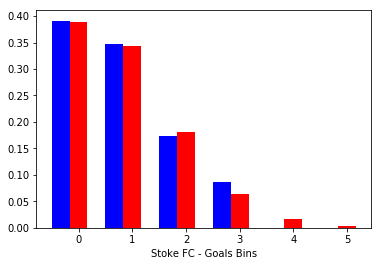

In [20]:
width = np.min(np.diff(team_dataframe_goal_frequency['goals']))/3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(team_dataframe_goal_frequency['goals']-width,relative_frequency,width,color='b',label='-Ymin')
ax.bar(team_dataframe_goal_frequency['goals'],zip_pmf(team_dataframe_goal_frequency['goals'],out.params['zip_phi_param'].value,out.params['poisson_distribution_mean'].value),width,color='r',label='Ymax')
ax.set_xlabel('Stoke FC - Goals Bins')
plt.show()

As it can be seen above the blue which is actual goals is closley matched by the zero inflated estimation in red, the last part which 
I won't delve to for now is the use of the chi-squared distribution to see how well the estimate fits the data  